<h1 align="center"> Tutorial: scikit-learn new features</h1>

<br />
<div align="center">April 28, 2019</div>
<br />

<div align="center">Roman Yurchak (notebook adapted from work by Olivier Grisel)</div>

Running this notebooks requires Python 3.5+ as well as,
 - scikit-learn >=0.21.2
 - matplotlib
 - pandas

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## 1. Example: the California housing dataset

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import median_absolute_error


calhousing = fetch_california_housing()

X = pd.DataFrame(calhousing.data, columns=calhousing.feature_names)
y = pd.Series(calhousing.target, name='house_value')

/home/rth/src/scikit-learn/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
print(calhousing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [4]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [5]:
y.head().to_frame()

,house_value
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


## 2. Spatial clustering

Let's looks at the spatial distribution of census block groups, and the corresponding median house value,

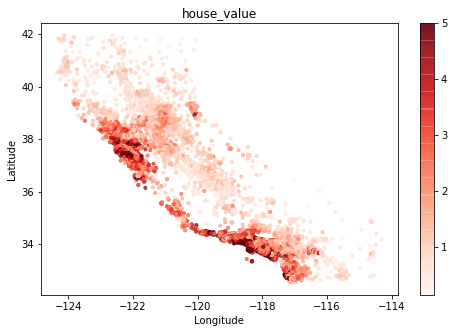

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

X.plot.scatter('Longitude', 'Latitude', c=y, ax=ax,
               colorbar=True, colormap='Reds', alpha=0.7, s=10)
ax.set_title(y.name);

Could we try to detect geographical entities (towns, cities) from this spatial distribution?

n_clusters: 59
CPU times: user 578 ms, sys: 157 ms, total: 734 ms
Wall time: 541 ms


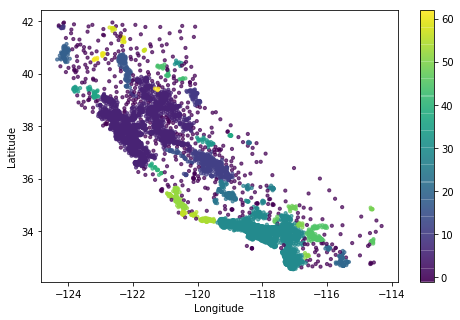

In [7]:
%%time

from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.1).fit(X[['Longitude', 'Latitude']])


fig, ax = plt.subplots(1, 1, figsize=(8, 5))

labels = dbscan.labels_
labels[labels>=0] += 5
print('n_clusters:', len(np.unique(labels)))

X.plot.scatter('Longitude', 'Latitude', c=labels, ax=ax,
               colorbar=True, colormap='viridis', alpha=0.7, s=10);

Samples that don't belong to any cluster (noisy samples) have a value of -1.

The choice of `eps` parameter will strongly impact both the number of clusters and the fraction of noisy samples in DBSCAN.

/home/rth/src/scikit-learn/sklearn/cluster/optics_.py:795: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


n_clusters: 743
CPU times: user 44.8 s, sys: 133 ms, total: 44.9 s
Wall time: 44.7 s


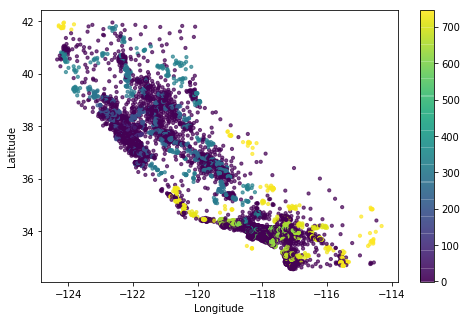

In [8]:
%%time

from sklearn.cluster import OPTICS

cl = OPTICS().fit(X[['Longitude', 'Latitude']])

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

labels = cl.labels_
labels[labels>=0] += 5
print('n_clusters:', len(np.unique(labels)))

X.plot.scatter('Longitude', 'Latitude', c=labels, ax=ax,
               colorbar=True, colormap='viridis', alpha=0.7, s=10);

## 3. Baseline supervised model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1000, random_state=0)

Let's start with a quick baseline model: linear regression (aka. Ordinary Least Squares):

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

%time lm = LinearRegression().fit(X_train, y_train)

CPU times: user 6.54 ms, sys: 6.03 ms, total: 12.6 ms
Wall time: 4.14 ms


In [11]:
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train, lm.predict(X_train)),
       median_absolute_error(y_test, lm.predict(X_test))))

train error: 0.413, test error: 0.419


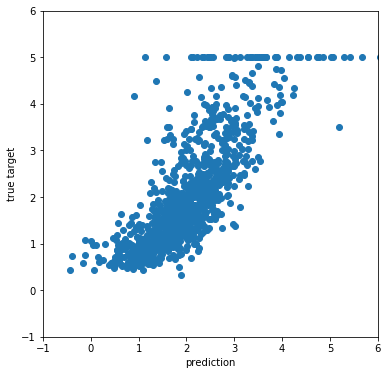

In [12]:
def scatter_predictions(y_pred, y_true):
    plt.figure(figsize=(6, 6))
    plt.xlabel('prediction')
    plt.ylabel('true target')
    plt.xlim(-1, 6)
    plt.ylim(-1, 6)
    plt.scatter(y_pred, y_true)
    
scatter_predictions(lm.predict(X_test), y_test)

This is pretty bad: the errors (off-diagonal predictions) seems to be heteroschedastic and there is a saturation effect with many samples with `y_true == 5`. Let's check:

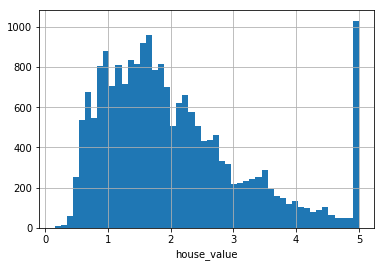

In [13]:
ax = y.hist(bins=50)

ax.set_xlabel(y.name);

We can filter out the "anomalies" and make the target variable marginal distribution more "Gaussian" by taking the log:

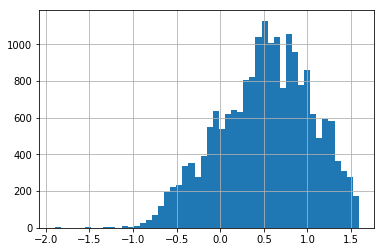

In [14]:
np.log(y[y<4.9]).hist(bins=50);

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X[y<4.9], y[y<4.9], test_size=1000, random_state=0)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


lm2 = make_pipeline(StandardScaler(), LinearRegression())
_ = %time lm2.fit(X_train, np.log(y_train))

CPU times: user 12.8 ms, sys: 14.9 ms, total: 27.8 ms
Wall time: 16.2 ms


In [17]:
print("train error: %0.3f, test error: %0.3f" %
      (median_absolute_error(y_train,
                             np.exp(lm2.predict(X_train))),
       median_absolute_error(y_test,
                             np.exp(lm2.predict(X_test)))))

train error: 0.325, test error: 0.331


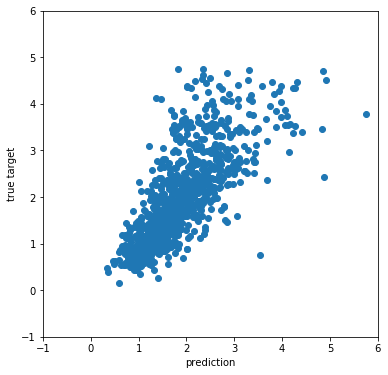

In [18]:
scatter_predictions(
    np.exp(lm2.predict(X_test)),
    y_test)

## 4. Feature engineering / preprocessing

To facilitate the evaluation of subsequent models, let's factorize the evaluation code into a separate function,

In [19]:
from pickle import dumps

def train_score_model(
        model, X_train, X_test, y_train, y_test, plot=False
):
    %time model.fit(X_train, np.log(y_train))

    print("train error: %0.3f, test error: %0.3f" %
          (median_absolute_error(
              y_train, np.exp(model.predict(X_train))),
           median_absolute_error(
              y_test,  np.exp(model.predict(X_test)))))
    
    model_size = len(dumps(model)) / 1e6
    if model_size > 0.1:
        print("Model size: %0.2f MB" % (model_size))

    if plot:
        scatter_predictions(
            np.exp(model.predict(X_test)), y_test
        )
    return model

train_score_model(lm2, X_train, X_test, y_train, y_test);

CPU times: user 15.2 ms, sys: 5.22 ms, total: 20.5 ms
Wall time: 13.1 ms
train error: 0.325, test error: 0.331


Now, let's examine more closely the distribution of different features. Most are assymetric distributions with a long tail.

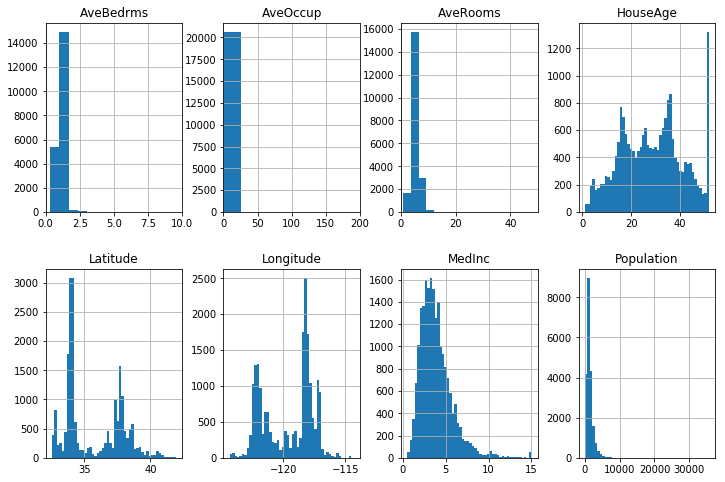

In [20]:
fig, ax = plt.subplots(2, 4, figsize=(12, 8))
X.hist(ax=ax, bins=50);
ax[0,0].set_xlim(0, 10)
ax[0,1].set_xlim(0, 200)
ax[0,2].set_xlim(0, 50);

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import make_union

plm = make_pipeline(
    ColumnTransformer([
        ('scaler', StandardScaler(),
         ['Latitude', 'Longitude', "HouseAge"]),
        ('power_transform', PowerTransformer(),
         ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup'])
    ]),
    LinearRegression())

train_score_model(plm, X_train, X_test, y_train, y_test);

CPU times: user 206 ms, sys: 46.9 ms, total: 253 ms
Wall time: 178 ms
train error: 0.295, test error: 0.295


We use `ColumnsTransformer` to selectively apply Yeo-Johnson power transform on some features, while keeping `StandardScaler` for others.

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union

plm = make_pipeline(
    StandardScaler(),
    make_union(
        FunctionTransformer(validate=True),
        PolynomialFeatures(degree=3)
    ),
    LinearRegression())

train_score_model(plm, X_train, X_test, y_train, y_test);

CPU times: user 845 ms, sys: 383 ms, total: 1.23 s
Wall time: 368 ms
train error: 0.266, test error: 0.259


## 5. Model improvement

In this part, we keep the baseline feature scaling, while evaluating more advanced models.

In [23]:
from sklearn.neural_network import MLPRegressor

mlp = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(100, 10, 10), activation='relu'),
)

train_score_model(mlp, X_train, X_test, y_train, y_test);

CPU times: user 10.6 s, sys: 169 ms, total: 10.8 s
Wall time: 10.5 s
train error: 0.200, test error: 0.200


CPU times: user 6.63 s, sys: 171 ms, total: 6.8 s
Wall time: 6.54 s
train error: 0.125, test error: 0.171
Model size: 1.38 MB


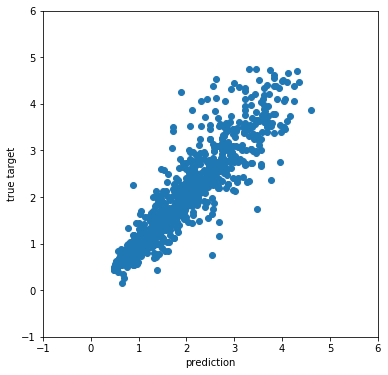

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=8, min_samples_leaf=20,
                                n_estimators=100, loss='huber')

train_score_model(gbr, X_train, X_test, y_train, y_test, plot=True);

In [25]:
%timeit gbr.predict(X_test[:100])

1.53 ms ± 58.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)

train_score_model(rfr, X_train, X_test, y_train, y_test);

CPU times: user 17.9 s, sys: 81.5 ms, total: 17.9 s
Wall time: 4.76 s
train error: 0.063, test error: 0.168
Model size: 148.53 MB


In [27]:
%timeit rfr.predict(X_test[:100])

110 ms ± 3.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### New Histogram-based Gradient Boosting Trees

In [28]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [29]:
hgbr = HistGradientBoostingRegressor(min_samples_leaf=20, max_leaf_nodes=256,
                                     max_iter=100)
train_score_model(hgbr, X_train, X_test, y_train, y_test);

CPU times: user 13.1 s, sys: 246 ms, total: 13.4 s
Wall time: 3.76 s
train error: 0.087, test error: 0.163
Model size: 2.38 MB


In [30]:
%timeit hgbr.predict(X_test[:100])

2.9 ms ± 116 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 6. Early stopping

In [31]:
hgbr = HistGradientBoostingRegressor(
    min_samples_leaf=20, max_leaf_nodes=256,
    n_iter_no_change=5, validation_fraction=0.1,
    scoring="loss", max_iter=10000
)

train_score_model(hgbr, X_train, X_test, y_train, y_test);

CPU times: user 7.2 s, sys: 69 ms, total: 7.27 s
Wall time: 1.98 s
train error: 0.113, test error: 0.173
Model size: 1.44 MB


In [32]:
hgbr.n_iter_

60

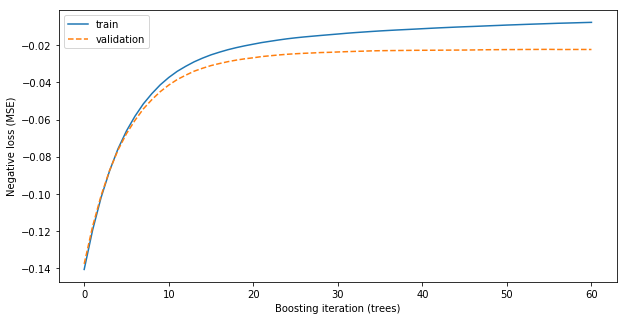

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hgbr.train_score_, label="train")
ax.plot(hgbr.validation_score_, "--", label="validation")
ax.set_xlabel("Boosting iteration (trees)")
ax.set_ylabel("Negative loss (MSE)")
ax.legend();

## 7. Imputation

Let's artificially create some missing data so that we can illustrate the imputation estimators.

In [34]:
rng = np.random.RandomState(42)

density = 4  # one in 10 values will be NaN

mask = rng.randint(density, size=X.shape) == 0
X_na = X.copy()
X_na.values[mask] = np.nan
X_na.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,NaN,1.023810,322.0,2.555556,NaN,NaN
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,NaN
2,7.2574,52.0,8.288136,1.073446,496.0,NaN,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,NaN,NaN
4,3.8462,52.0,6.281853,NaN,565.0,NaN,NaN,-122.25


In [35]:
X_train_na, X_test_na, y_train_na, y_test_na = train_test_split(
    X_na[y<4.9], y[y<4.9], test_size=1000, random_state=0)

In [36]:
from sklearn.impute import SimpleImputer

model = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy="median"),
    LinearRegression()
)
print('Baseline model\n')
train_score_model(model, X_train, X_test, y_train, y_test);
print('\nBaseline model with missing data + SimpleImputer\n')
train_score_model(model, X_train_na, X_test_na, y_train_na, y_test_na);

Baseline model

CPU times: user 37.3 ms, sys: 12.6 ms, total: 49.9 ms
Wall time: 26.2 ms
train error: 0.325, test error: 0.331

Baseline model with missing data + SimpleImputer

CPU times: user 65 ms, sys: 58.3 ms, total: 123 ms
Wall time: 31.6 ms
train error: 0.440, test error: 0.455


In [37]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

pipe = make_pipeline(
    StandardScaler(),
    IterativeImputer(),
    LinearRegression()
)

train_score_model(pipe, X_train_na, X_test_na, y_train_na, y_test_na);

CPU times: user 989 ms, sys: 899 ms, total: 1.89 s
Wall time: 485 ms
train error: 0.385, test error: 0.365


/home/rth/src/scikit-learn/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


With `IterativeImputer` we almost fully compensate the existence of missing values with respect to the baseline performance.

## Tricks

### Warm started models

In [38]:
X_train_small, X_val, y_train_small, y_val = train_test_split(
    X_train, y_train, train_size=5000, test_size=1000)

val_errors = []
train_errors = []


gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=8,
                                min_samples_leaf=3, n_estimators=1)

gbr.fit(X_train_small, y_train_small)

train_error = median_absolute_error(y_train, gbr.predict(X_train))
val_error = median_absolute_error(y_test, gbr.predict(X_test))

train_errors.append(train_error)
val_errors.append(val_error)

print("train error: %0.3f, test error: %0.3f" % (train_error, val_error)) 

train error: 0.632, test error: 0.666


In [39]:
for i in range(100):
    gbr.set_params(warm_start=True, n_estimators=len(gbr.estimators_) + 1)
    gbr.fit(X_train_small, y_train_small)
    train_error = median_absolute_error(y_train, gbr.predict(X_train))
    val_error = median_absolute_error(y_test, gbr.predict(X_test))

    train_errors.append(train_error)
    val_errors.append(val_error)
    if (i + 2) % 10 == 0:
        print("n_trees=%d, train error: %0.3f, test error: %0.3f"
              % (len(gbr.estimators_), train_error, val_error)) 

n_trees=10, train error: 0.365, test error: 0.380
n_trees=20, train error: 0.249, test error: 0.260
n_trees=30, train error: 0.206, test error: 0.225
n_trees=40, train error: 0.189, test error: 0.221
n_trees=50, train error: 0.182, test error: 0.218
n_trees=60, train error: 0.176, test error: 0.216
n_trees=70, train error: 0.171, test error: 0.216
n_trees=80, train error: 0.168, test error: 0.214
n_trees=90, train error: 0.162, test error: 0.213
n_trees=100, train error: 0.159, test error: 0.209


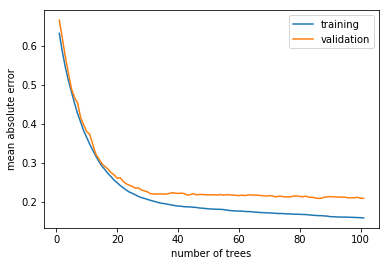

In [40]:
tree_indices = np.arange(len(val_errors)) + 1
plt.plot(tree_indices, train_errors, label='training')
plt.plot(tree_indices, val_errors, label='validation')
plt.xlabel('number of trees')
plt.ylabel('mean absolute error')
plt.legend(loc='best');

### Categorical features encoded as integers

One-hot encoding is pretty useless for tree-based models (at least in scikit-learn). Contrary to other models it's pretty safe and much more efficient to use integer based encoding for instance using pandas:

```python
    >>> categorical_data.apply(lambda x: pd.factorize(x)[0])
```

alternatively you can use scikit-learn's [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).